# Runtime & Memory Profiling Exploration

This is a notebook to figure out how to measure runtime and memory for different classification model pipelines. 

In [1]:
# used for all classifier pipelines 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

## Loading the 20 Newsgroups Dataset

Here I download the 20 News Grops data  background information on this dataset, [check out this link](http://qwone.com/~jason/20Newsgroups/).  I also create the testing and training sets.

In [2]:
from sklearn.datasets import fetch_20newsgroups

mydata_train = fetch_20newsgroups(subset='train', shuffle=True, 
                                  remove = ('headers', 'footers', 'quotes'), 
                                  random_state=42)

mydata_test = fetch_20newsgroups(subset='test', shuffle=True,
                                 remove = ('headers', 'footers', 'quotes'), 
                                 random_state=42)

print('size of training set: %s' % (len(mydata_train ['data'])))
print('size of validation set: %s' % (len(mydata_test['data'])))

size of training set: 11314
size of validation set: 7532


Printing the first few lines of one of the items in the training data. 

In [3]:
print("\n".join(mydata_train.data[3].split("\n")[:5]))


Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.



Get an idea of how the classes of this data are distributed

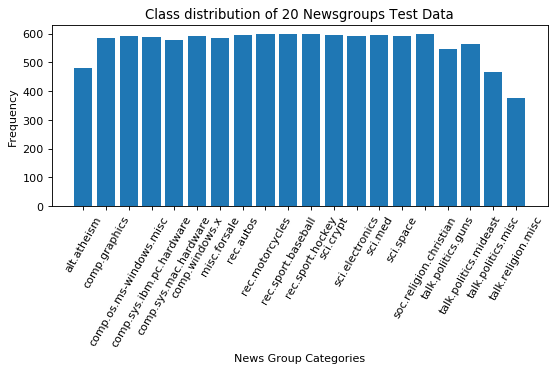

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

targets, frequency = np.unique(mydata_train.target, return_counts=True)

fig = plt.figure(figsize=(8, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(mydata_train.target_names, frequency)
plt.title('Class distribution of 20 Newsgroups Test Data')
plt.xticks(rotation=60)
plt.xlabel('News Group Categories')
plt.ylabel('Frequency')
plt.show()

This is a quick DataFrame view of what this dataset looks like

In [5]:
import pandas as pd
mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})
mydata_train_df.head()

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


## Creating Pipelines with Logistic Regression
Here we abstract the feature extraction to training process by using a [Pipeline object](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class. 

In [6]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())])

# fittingthe data
lr_pipeline.fit(mydata_train.data, mydata_train.target)
print(lr_pipeline.score(mydata_test.data, mydata_test.target))

/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6775092936802974


Now we add truncated SVD to the pipeline. We reduce the dimensions to 100.  

In [7]:
lr_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
         ('svd', TruncatedSVD(n_components=100)),
        ('clf', LogisticRegression())])

# fittingthe data
lr_pipeline.fit(mydata_train.data, mydata_train.target)
print(lr_pipeline.score(mydata_test.data, mydata_test.target))

/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.5463356346255974


Beacause you're losing a lot of information when you reduce dimensions from 10,000+ to 100 so it's not surprising to me that the F-score is lower. 

## Measuring Runtime: Logistic Regression

Now we measure the runtime of computing predictions on the testing dataset. 
The `n` controls how many executions are done for each timing and it's used to get representative timings. 
The `r` repeat argument controls how many timings are done and its use is to get accurate statistics.  
That said, the [documentation](https://docs.python.org/3/library/timeit.html#timeit.Timer.repeat) for `timeit` states the following:

> Note: It’s tempting to calculate mean and standard deviation from the result vector and report these. *However, this is not very useful*. In a typical case, the lowest value gives a lower bound for how fast your machine can run the given code snippet; higher values in the result vector are typically not caused by variability in Python’s speed, but by other processes interfering with your timing accuracy. So the min() of the result is probably the only number you should be interested in. After that, you should look at the entire vector and apply common sense rather than statistics.

In [10]:
import timeit
# will pick a larger n for the real thing
results = %timeit -r 3 -n 10 -o lr_pipeline.predict(mydata_train.data)

3.4 s ± 551 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


The minimum of the `r` measurements.  This is the statistic of interest

In [11]:
results.best

2.6383488784999996

In [12]:
# these are the r measurements 
np.array(results.all_runs)/10

array([2.63834888, 3.63110203, 3.92608132])

## Measuring Memory: Logistic Regression

Here we measure the size of the Logistic Regression Pipeline project. 

In [13]:
lr_pipeline['clf']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
%load_ext memory_profiler

Memory profiler measures the peak memory.  This is far more complex than just measuring the size of each of the models. 

In [15]:
%memit lr_pipeline

peak memory: 332.88 MiB, increment: 0.05 MiB


Here we try another solution from [this website](https://goshippo.com/blog/measure-real-size-any-python-object/)
that uses `sys` to recursively finds the size of the object.  


In [1]:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [17]:
get_size(lr_pipeline, seen=None)

14558301

Here we try a package called `pympler` [link to docs](https://pythonhosted.org/Pympler/asizeof.html#asizeof).
I think this mightbe the best tool for what we're looking to do which is to understand the size of the pipeline project we're working with.  
The result here is pretty close to 

In [18]:
from pympler import asizeof
asizeof.asizeof(lr_pipeline)

14879664

## Profiling Random Forest
Here we repeat what we did for logistic regression with a Random Forest classifier. 

We first start with a 100 tree classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', RandomForestClassifier(n_estimators=100))])

rf_pipeline.fit(mydata_train.data, mydata_train.target)
print(rf_pipeline.score(mydata_test.data, mydata_test.target))

/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.44052044609665425


In [20]:
# will increase r & n later
results = %timeit -r 3 -n 10 -o rf_pipeline.predict(mydata_test.data)

1.53 s ± 20.4 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [21]:
rf_time = results.best
rf_time

1.5164672260999992

Here we try the two memory profiling approaches again.  They're both pretty close.   The `pympler` method results in higher values than the `get_size` function. 

In [22]:
get_size(rf_pipeline, seen=None)

14563778

In [23]:
asizeof.asizeof(rf_pipeline)

14885408